In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import pickle
import argparse
import torch
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report
from pathlib import Path
import seaborn as sns
import random
sys.path.insert(0, '..')
from config import *
from util.plot_utils import obtain_plot, plot_logs
from tqdm.notebook import tqdm
from train_binary_cl import get_args_parser, create_data_loader_test
from models.mlp import build as build_model 
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

/home/gbini/miniconda3/envs/rnarna/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/data01/gbini/miniconda3/envs/rnarna/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
parser = argparse.ArgumentParser('Training', parents=[get_args_parser()])
args = parser.parse_args()
layer = str(args.embedding_layer)
args.layer_folder = os.path.join(embedding_dir, args.k, layer)
folder_name = f'NTlayer{layer}_dividing_factor{args.dividing_factor}_hiddenlayers{args.num_hidden_layers}'
args.output_dir = os.path.join(ROOT_DIR, 'checkpoints', 'nt', folder_name)
args.dataset_path = os.path.join(ROOT_DIR, 'dataset')
args.device = 'cuda:0'
args.resume = os.path.join(args.output_dir, 'checkpoint.pth')
args.layer_folder = os.path.join(embedding_dir, args.k, layer)
folder_path = os.path.join(args.layer_folder, 'val')

In [4]:
set_data = 'val' 
assert set_data in ['val', 'test']
done = list(pd.read_csv(os.path.join(metadata_dir,f'done_{set_data}.txt'), header = None)[0])
excluded = list(pd.read_csv(os.path.join(metadata_dir,f'excluded_{set_data}.txt'), header = None)[0])
meta = pd.read_csv(os.path.join(metadata_dir, f'{set_data}.csv'))
meta = meta[meta.id_sample.isin(done)]
meta = meta[~meta.id_sample.isin(excluded)]

In [5]:
device = torch.device(args.device)
model = build_model(args)
model.to(device)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [6]:
start_time = time.time()
model.eval()

probability = []
ground_truth = []
g1 = []
g2 = []
policy = []
len_g1 = []
len_g2 = []
couple_id = []
original_length1 = []
original_length2 = []

for _, row in tqdm(meta.iterrows(), total =meta.shape[0] ):
    class_label = 'class_1' if row.interacting else 'class_0'
    class_folder = os.path.join(folder_path, class_label)
    sample_file = str(row.id_sample) + '.npy'
    sample = np.load(os.path.join(class_folder, sample_file))
    inputs = torch.from_numpy(np.expand_dims(sample, axis = 0)).float().to(device)
    outputs = model(inputs)
    probability += outputs.softmax(-1)[:, 1].tolist()
    
    ground_truth.append(1 if row.interacting else 0)
    policy.append(row['policy'])
    couple_id.append(row['couple'])
    g1.append(row['gene1'])
    g2.append(row['gene2'])
    len_g1.append(row.x2 - row.x1)
    len_g2.append(row.y2 - row.y1)
    original_length1.append(row['original_length1'])
    original_length2.append(row['original_length2'])

res = pd.DataFrame({
    'probability':probability,
    'ground_truth':ground_truth,
    'g1':g1,
    'g2':g2,
    'policy':policy,
    'len_g1': len_g1,
    'len_g2': len_g2,
    'couples':couple_id,
    'original_length1':original_length1,
    'original_length2':original_length2
})

res['prediction'] = (res['probability'] > 0.5).astype(int)

(res['prediction'] == res['ground_truth']).sum()/res.shape[0]

res['sampled_area'] = res['len_g1']*res['len_g2']

res['matrix_area'] = res['original_length1']*res['original_length2']

  0%|          | 0/37832 [00:00<?, ?it/s]

In [7]:
print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.62      0.27      0.38     18914
           1       0.53      0.83      0.65     18918

    accuracy                           0.55     37832
   macro avg       0.58      0.55      0.52     37832
weighted avg       0.58      0.55      0.52     37832



# Plots

### Log plots

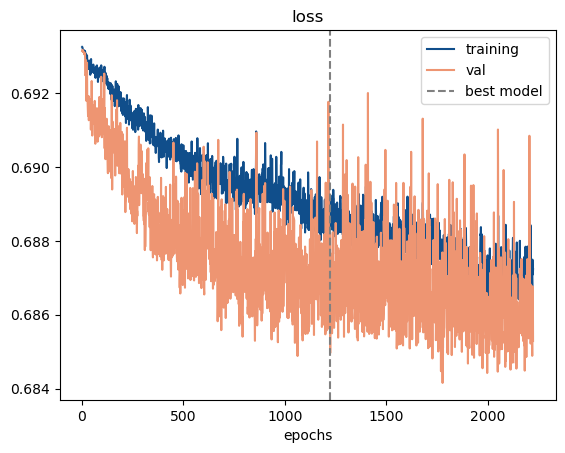

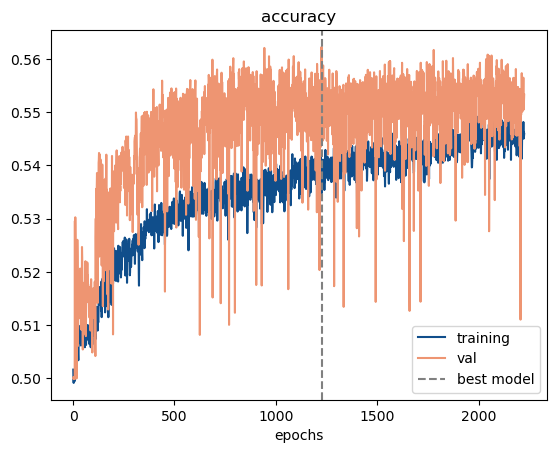

In [7]:
#epoch 1110 validation is fixed!
folder_name = f'NTlayer{layer}_dividing_factor{args.dividing_factor}_hiddenlayers{args.num_hidden_layers}'
#folder_name ='NTlayer22_dividing_factor80_hiddenlayers3'
log = pd.read_json(Path(os.path.join(ROOT_DIR, 'checkpoints', 'nt', folder_name, 'log.txt')), lines=True)
best_model = np.argmax(log.test_accuracy) #np.argmin(log.test_loss)
log=log[1:]
for metric in ['loss', 'accuracy']:
    plot_logs(log, metric, best_model = best_model)

### Other plots

In [164]:
df = pd.read_csv(os.path.join(processed_files_dir,"final_df.csv"), sep = ',')[['couples', 'protein_coding_1', 'protein_coding_2']]
assert df.merge(res, on = 'couples').shape[0] >= res.shape[0]
if df.merge(res, on = 'couples').shape[0] > res.shape[0]:
    print(f"Be careful, some prediction will be counted more than one time. The number of duplicated sequences is {(df.merge(res, on = 'couples').shape[0]-res.shape[0])}")
res = df.merge(res, on = 'couples')
res=res.rename({'protein_coding_1': 'gene1_pc'}, axis = 1)
res=res.rename({'protein_coding_2': 'gene2_pc'}, axis = 1)

Be careful, some prediction will be counted more than one time. The number of duplicated sequences is 160


In [165]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

1    22628
0    15364
Name: prediction, dtype: int64


1    19078
0    18914
Name: ground_truth, dtype: int64


In [166]:
n_conf = 10

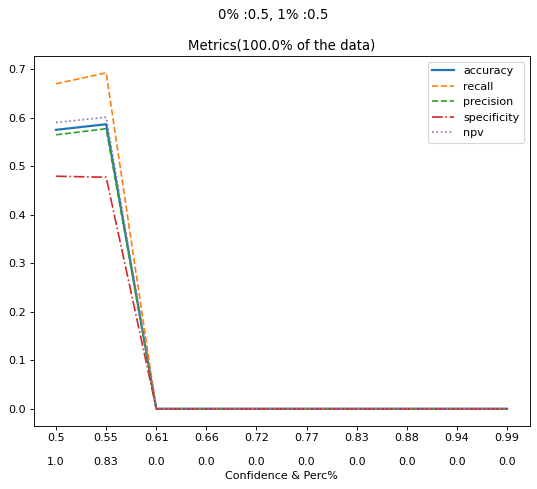

In [167]:
obtain_plot(res, n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

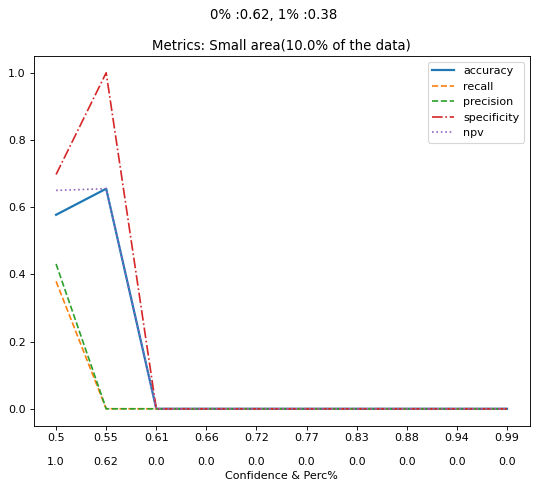

In [13]:
small_areas = res.sampled_area.quantile(0.1)

small_areas = res[res['sampled_area'] < small_areas]

obtain_plot(small_areas, n_original_df = res.shape[0], title = f'Metrics: Small area', n_conf = n_conf)

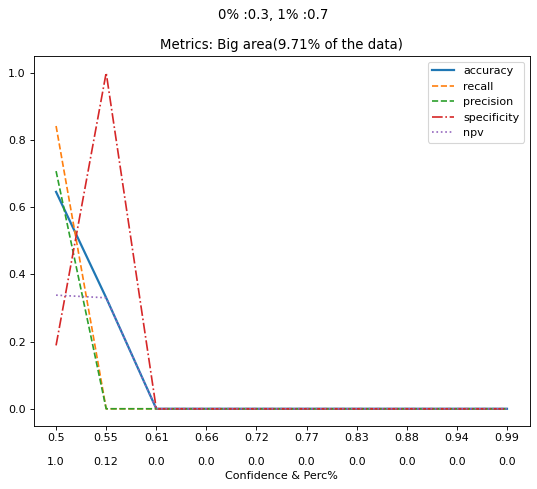

In [14]:
big_area = res.sampled_area.quantile(0.9)

big_area = res[res['sampled_area'] > big_area]

obtain_plot(big_area, n_original_df = res.shape[0], title = f'Metrics: Big area', n_conf = n_conf)

Anziche vedere la grandezza della matrice campionata, vediamola in rapporto alla dimensione della matrice originale, cosi possiamo misurare la "quantita di informazione persa per via del campionamento"

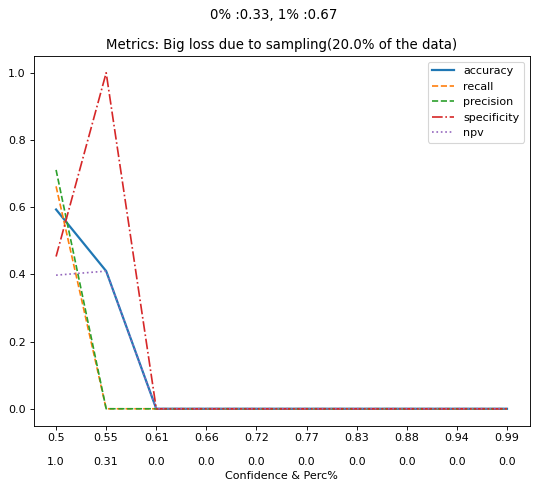

In [16]:
res['area_ratio'] = res['sampled_area']/res['matrix_area']

big_loss = res.area_ratio.quantile(0.2)

big_loss = res[res['area_ratio'] < big_loss] 
obtain_plot(big_loss, n_original_df = res.shape[0], title = f'Metrics: Big loss due to sampling', n_conf = n_conf)

In [17]:
small_loss = res.area_ratio.quantile(0.8)

small_loss = res[res['area_ratio'] > small_loss]

obtain_plot(small_loss, n_original_df = res.shape[0], title = f'Metrics: Small loss due to sampling', n_conf = n_conf)

ZeroDivisionError: division by zero

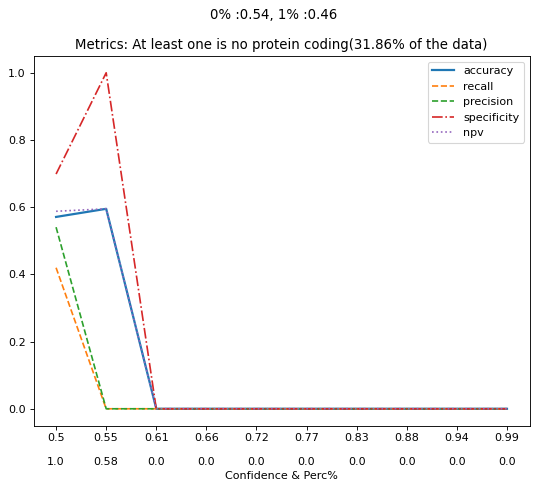

In [18]:
no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

obtain_plot(no_pc, n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

In [19]:
hard = res[(res.policy == 'hardpos')|(res.policy == 'hardneg')]

obtain_plot(hard, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of hardpos, specificity is the accuracy of hardneg ', n_conf = n_conf)

ZeroDivisionError: division by zero

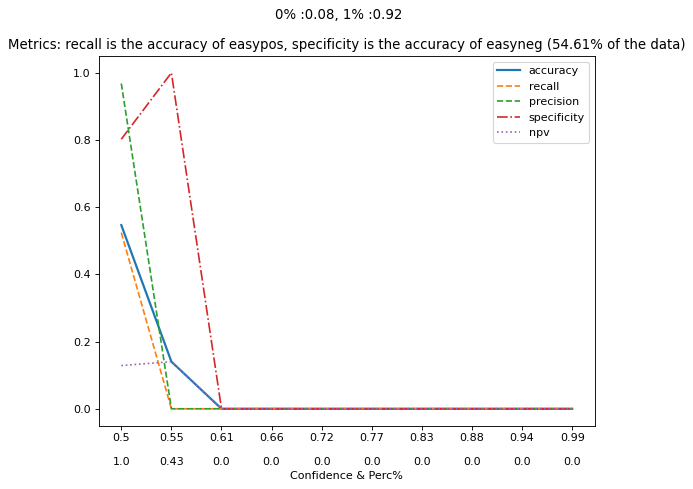

In [20]:
easy = res[(res.policy == 'easypos')|(res.policy == 'easyneg')]

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of easyneg ', n_conf = n_conf)

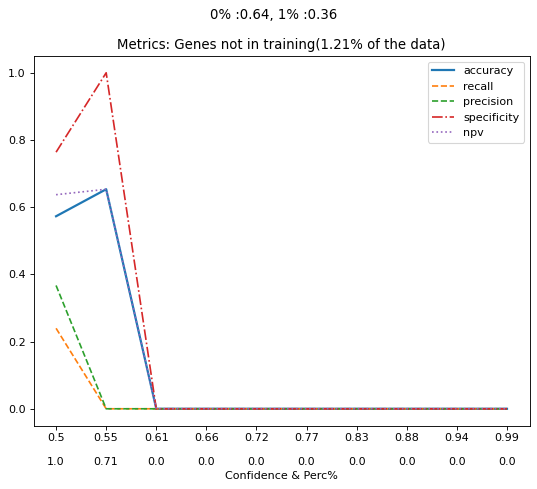

In [25]:
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
df_train = pd.DataFrame({'couples':gene_pairs_train})
regex = df_train['couples'].str.extractall('(.*)_(.*)').reset_index()
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

not_in_train = res[~(res.g1.isin(df_train_genes) | res.g2.isin(df_train_genes))]

obtain_plot(not_in_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training', n_conf = n_conf)

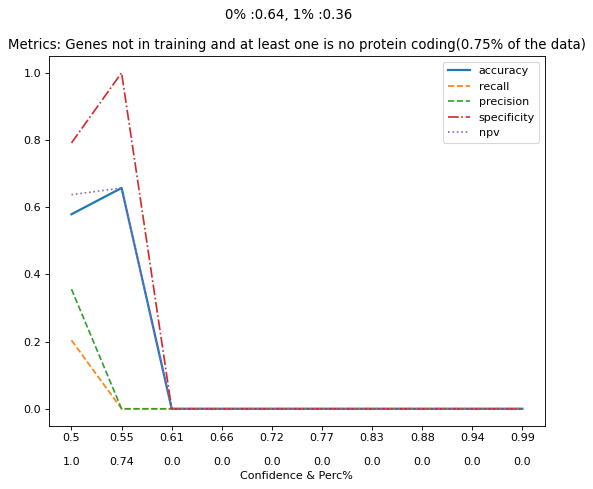

In [26]:
no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]

obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding', n_conf = n_conf)

In [ ]:
high_prob_pairs = res[res.probability>0.9]


obtain_plot(high_prob_pairs, n_original_df = res.shape[0], title = f'Metrics: Pairs where my model is very confident', n_conf = n_conf)

# Sequence similarity analysis
Let's now analyze the cluster results

Per la valutazione del clustering, utilizza 2 criteri. Il primo è quello che hai gia implementato. Se il gene 1 del test sta in un cluster in cui ci sono geni del training, escludo tutte le coppie dove compare il gene 1 dal test per la stima delle performance. Il secondo metodo di valutazione è meno restrittivo: abbiamo la coppia 1-2 nel test e la coppia 3-4 nel training. La sequenza 1 sta nel cluster X, la sequenza 2 sta nel cluster Y. Se abbiamo una coppia di geni del training 3-4 in cui ad esempio 4 sta nel cluster X e 3 sta nel cluster Y, allora escludo 1-2 dalla stima delle performance. Se invece 4 sta nel cluster X e 3 sta nel cluster Z, allora 1-2 la posso mettere. Usa questi metodi di valutazione sia per il clustering fatto fino ad ora sia per il clustering full length.

### Slice

In [30]:
cl = pd.read_csv(os.path.join(processed_files_dir, 'cdhit_clusters.csv')) #mmseq2_clusters.csv

Approccio restrittivo

In [31]:
cl_train = cl[cl.couple.isin(gene_pairs_train)].reset_index(drop = True)
val_couples = set(res.couples)
cl_val = cl[cl.couple.isin(val_couples)].reset_index(drop = True)

cluster_train = set(cl_train.cl_name)
cluster_val = set(cl_val.cl_name)
cluster_val_not_in_train = cluster_val - cluster_train
couples_of_val_in_cl_not_in_train_overlapping = set(cl_val[cl_val.cl_name.isin(cluster_val_not_in_train)].couple)

In [32]:
no_pc_no_train_cl = no_pc_no_train[no_pc_no_train.couples.isin(couples_of_val_in_cl_not_in_train_overlapping)]

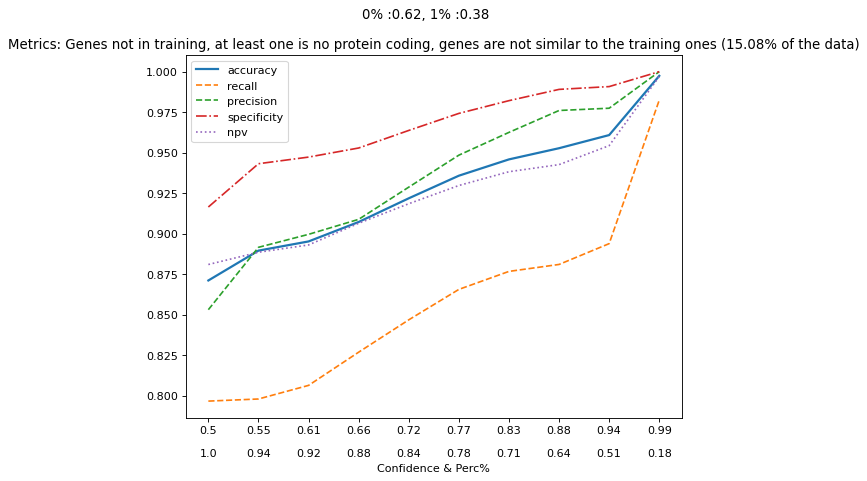

In [33]:
obtain_plot(no_pc_no_train_cl, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, at least one is no protein coding, genes are not similar to the training ones ', n_conf = n_conf)

In [34]:
no_pc_no_train_cl.prediction.value_counts()

0    1394
1     762
Name: prediction, dtype: int64

Approccio meno restrittivo

La percentuale di coppie che ha un unica combinazione di cluster è il 98.24%


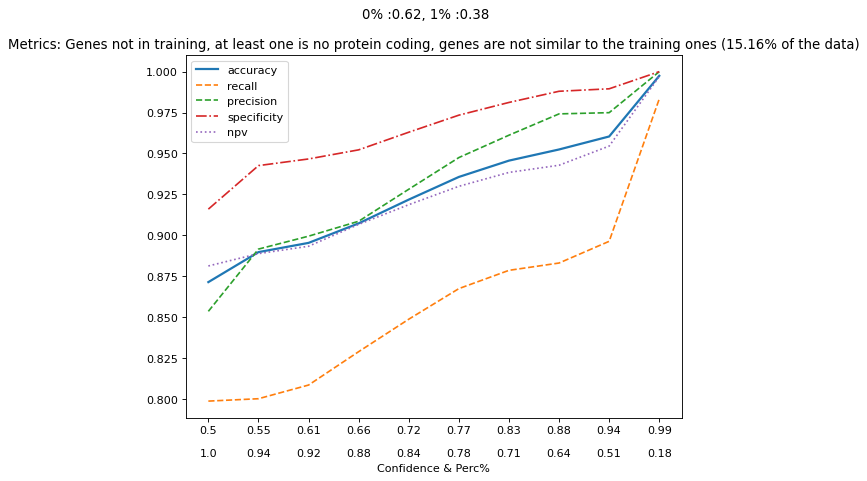

In [35]:
cl_ = cl.sort_values('cl_name', ascending = True).groupby('couple')['cl_name'].apply(list).apply(str).reset_index(name='cl_name')

p = np.round((len(cl_.cl_name.unique())/cl_.shape[0])*100, 2)
print(f'La percentuale di coppie che ha un unica combinazione di cluster è il {p}%')

cl_train_ = cl_[cl_.couple.isin(gene_pairs_train)].reset_index(drop = True)
cl_val_ = cl_[cl_.couple.isin(val_couples)].reset_index(drop = True)

cluster_train_ = set(cl_train_.cl_name)
cluster_val_ = set(cl_val_.cl_name)
cluster_val_not_in_train_ = cluster_val_ - cluster_train_
couples_of_val_in_cl_not_in_train_overlapping_ = set(cl_val_[cl_val_.cl_name.isin(cluster_val_not_in_train_)].couple)

no_pc_no_train_cl_ = no_pc_no_train[no_pc_no_train.couples.isin(couples_of_val_in_cl_not_in_train_overlapping_)]

obtain_plot(no_pc_no_train_cl_, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, at least one is no protein coding, genes are not similar to the training ones ', n_conf = n_conf)

### Full length clustering

In [36]:
cl1 = pd.read_csv(os.path.join(processed_files_dir, 'cdhit_clusters_fl_merged.csv')) #mmseq2_clusters.csv
cl2 = pd.read_csv(os.path.join(processed_files_dir, 'cdhit_clusters_fl2_merged.csv')) #mmseq2_clusters.csv

Cluster 1 - approccio restrittivo

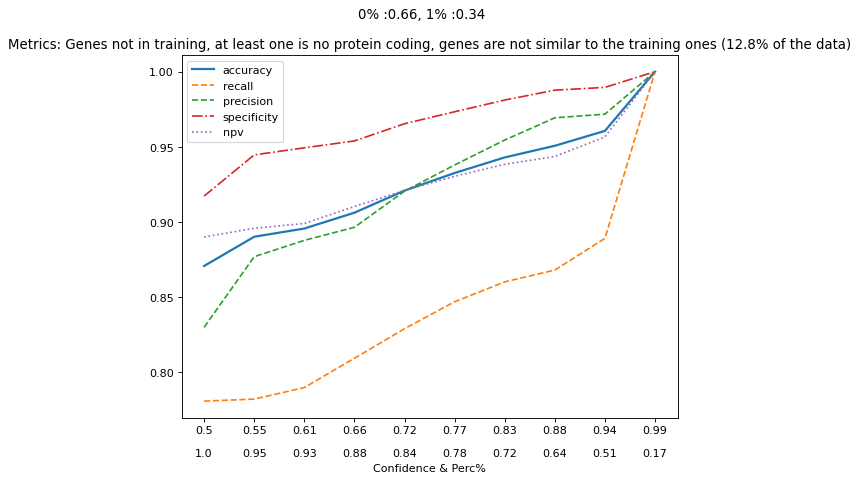

In [37]:
cl_train1 = cl1[cl1.couple.isin(gene_pairs_train)].reset_index(drop = True)
cl_val1 = cl1[cl1.couple.isin(val_couples)].reset_index(drop = True)

cluster_train1 = set(cl_train1.cl_name)
cluster_val1 = set(cl_val1.cl_name)
cluster_val_not_in_train1 = cluster_val1 - cluster_train1
couples_of_val_in_cl_not_in_train_overlapping1 = set(cl_val1[cl_val1.cl_name.isin(cluster_val_not_in_train1)].couple)

no_pc_no_train_cl1 = no_pc_no_train[no_pc_no_train.couples.isin(couples_of_val_in_cl_not_in_train_overlapping1)]

obtain_plot(no_pc_no_train_cl1, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, at least one is no protein coding, genes are not similar to the training ones ', n_conf = n_conf)

Cluster 1 - approccio meno restrittivo

In [38]:
cl1_ = cl1.sort_values('cl_name', ascending = True).groupby('couple')['cl_name'].apply(list).apply(str).reset_index(name='cl_name')

p1 = np.round((len(cl1_.cl_name.unique())/cl1_.shape[0])*100, 2)
print(f'La percentuale di coppie che ha un unica combinazione di cluster è il {p1}%')

La percentuale di coppie che ha un unica combinazione di cluster è il 97.88%


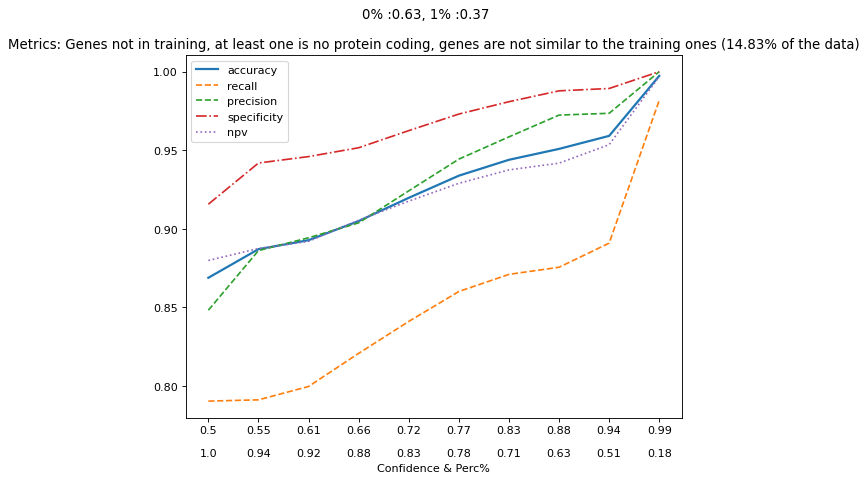

In [39]:
cl_train1_ = cl1_[cl1_.couple.isin(gene_pairs_train)].reset_index(drop = True)
cl_val1_ = cl1_[cl1_.couple.isin(val_couples)].reset_index(drop = True)

cluster_train1_ = set(cl_train1_.cl_name)
cluster_val1_ = set(cl_val1_.cl_name)
cluster_val_not_in_train1_ = cluster_val1_ - cluster_train1_
couples_of_val_in_cl_not_in_train_overlapping1_ = set(cl_val1_[cl_val1_.cl_name.isin(cluster_val_not_in_train1_)].couple)

no_pc_no_train_cl1_ = no_pc_no_train[no_pc_no_train.couples.isin(couples_of_val_in_cl_not_in_train_overlapping1_)]

obtain_plot(no_pc_no_train_cl1_, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, at least one is no protein coding, genes are not similar to the training ones ', n_conf = n_conf)

Cluster 2 - approccio restrittivo

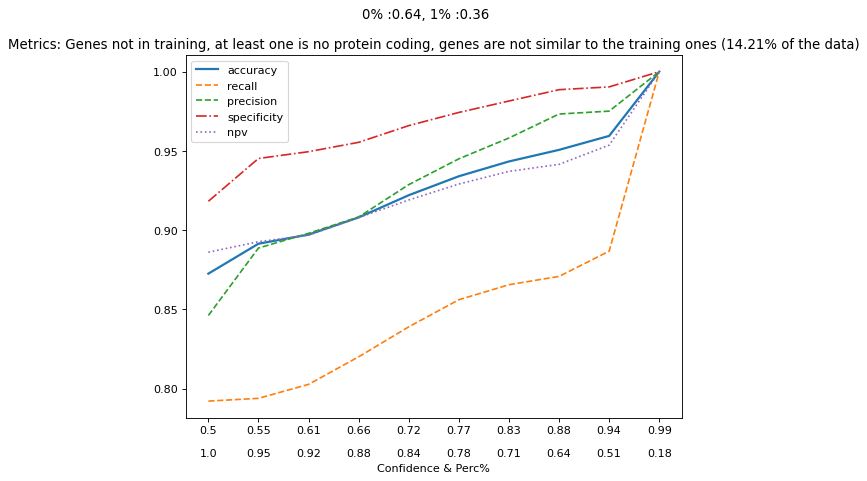

In [40]:
cl_train2 = cl2[cl2.couple.isin(gene_pairs_train)].reset_index(drop = True)
cl_val2 = cl2[cl2.couple.isin(val_couples)].reset_index(drop = True)

cluster_train2 = set(cl_train2.cl_name)
cluster_val2 = set(cl_val2.cl_name)
cluster_val_not_in_train2 = cluster_val2 - cluster_train2
couples_of_val_in_cl_not_in_train_overlapping2 = set(cl_val2[cl_val2.cl_name.isin(cluster_val_not_in_train2)].couple)

no_pc_no_train_cl2 = no_pc_no_train[no_pc_no_train.couples.isin(couples_of_val_in_cl_not_in_train_overlapping2)]

obtain_plot(no_pc_no_train_cl2, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, at least one is no protein coding, genes are not similar to the training ones ', n_conf = n_conf)

Cluster 1 - approccio meno restrittivo

La percentuale di coppie che ha un unica combinazione di cluster è il 98.04%


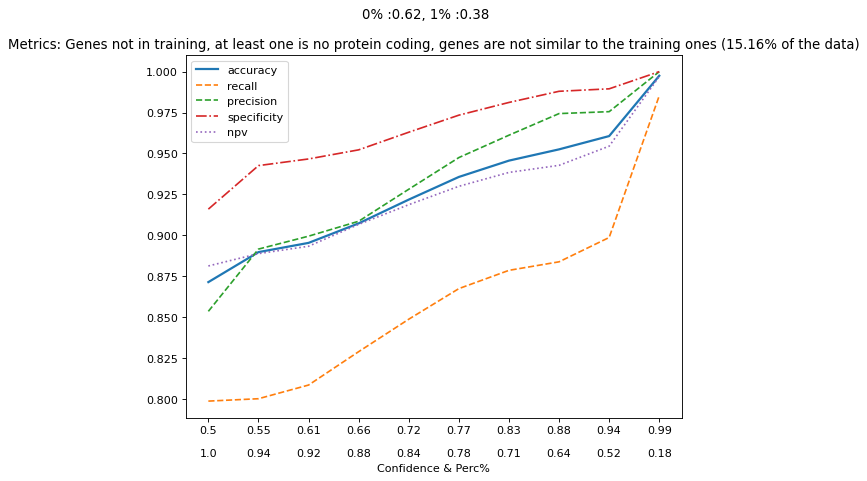

In [41]:
cl2_ = cl2.sort_values('cl_name', ascending = True).groupby('couple')['cl_name'].apply(list).apply(str).reset_index(name='cl_name')

p2 = np.round((len(cl2_.cl_name.unique())/cl2_.shape[0])*100, 2)
print(f'La percentuale di coppie che ha un unica combinazione di cluster è il {p2}%')

cl_train2_ = cl2_[cl2_.couple.isin(gene_pairs_train)].reset_index(drop = True)
cl_val2_ = cl2_[cl2_.couple.isin(val_couples)].reset_index(drop = True)

cluster_train2_ = set(cl_train2_.cl_name)
cluster_val2_ = set(cl_val2_.cl_name)
cluster_val_not_in_train2_ = cluster_val2_ - cluster_train2_
couples_of_val_in_cl_not_in_train_overlapping2_ = set(cl_val2_[cl_val2_.cl_name.isin(cluster_val_not_in_train2_)].couple)

no_pc_no_train_cl2_ = no_pc_no_train[no_pc_no_train.couples.isin(couples_of_val_in_cl_not_in_train_overlapping2_)]

obtain_plot(no_pc_no_train_cl2_, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, at least one is no protein coding, genes are not similar to the training ones ', n_conf = n_conf)

I am evaluating 32 sequences


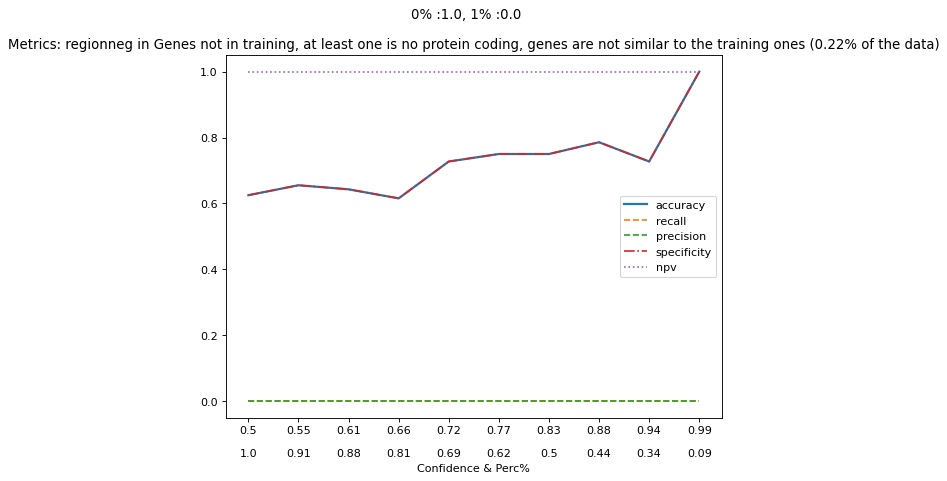

In [42]:
no_pc_no_train_cl2_regionneg = no_pc_no_train_cl2_[no_pc_no_train_cl2_.policy == 'regionneg']
print(f'I am evaluating {no_pc_no_train_cl2_regionneg.shape[0]} sequences')
obtain_plot(no_pc_no_train_cl2_regionneg, n_original_df = res.shape[0], title = f'Metrics: regionneg in Genes not in training, at least one is no protein coding, genes are not similar to the training ones ', n_conf = n_conf)